In [0]:
# Check GPU enable on Colab
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   1621      0 --:--:-- --:--:-- --:--:--  1629
Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
# Import
from fastai.collab import *
from fastai.tabular import *

# Collaborative filtering example

## Dataset (Movielens 100k)

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

Upload "ml-100k" dataset to colab

In [0]:
!unzip /content/data/ml-100k.zip -d /content/data

Archive:  /content/data/ml-100k.zip
   creating: /content/data/ml-100k/
  inflating: /content/data/ml-100k/allbut.pl  
  inflating: /content/data/ml-100k/mku.sh  
  inflating: /content/data/ml-100k/README  
  inflating: /content/data/ml-100k/u.data  
  inflating: /content/data/ml-100k/u.genre  
  inflating: /content/data/ml-100k/u.info  
  inflating: /content/data/ml-100k/u.item  
  inflating: /content/data/ml-100k/u.occupation  
  inflating: /content/data/ml-100k/u.user  
  inflating: /content/data/ml-100k/u1.base  
  inflating: /content/data/ml-100k/u1.test  
  inflating: /content/data/ml-100k/u2.base  
  inflating: /content/data/ml-100k/u2.test  
  inflating: /content/data/ml-100k/u3.base  
  inflating: /content/data/ml-100k/u3.test  
  inflating: /content/data/ml-100k/u4.base  
  inflating: /content/data/ml-100k/u4.test  
  inflating: /content/data/ml-100k/u5.base  
  inflating: /content/data/ml-100k/u5.test  
  inflating: /content/data/ml-100k/ua.base  
  inflating: /content/data/

In [0]:
path = Config.data_path()/"ml-100k"

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/ml-100k/u.info'),
 PosixPath('/root/.fastai/data/ml-100k/u3.test'),
 PosixPath('/root/.fastai/data/ml-100k/ub.test'),
 PosixPath('/root/.fastai/data/ml-100k/allbut.pl'),
 PosixPath('/root/.fastai/data/ml-100k/u1.base'),
 PosixPath('/root/.fastai/data/ml-100k/u2.base'),
 PosixPath('/root/.fastai/data/ml-100k/u4.test'),
 PosixPath('/root/.fastai/data/ml-100k/ub.base'),
 PosixPath('/root/.fastai/data/ml-100k/u2.test'),
 PosixPath('/root/.fastai/data/ml-100k/u5.base'),
 PosixPath('/root/.fastai/data/ml-100k/u5.test'),
 PosixPath('/root/.fastai/data/ml-100k/mku.sh'),
 PosixPath('/root/.fastai/data/ml-100k/u3.base'),
 PosixPath('/root/.fastai/data/ml-100k/ua.test'),
 PosixPath('/root/.fastai/data/ml-100k/u1.test'),
 PosixPath('/root/.fastai/data/ml-100k/u.user'),
 PosixPath('/root/.fastai/data/ml-100k/u.data'),
 PosixPath('/root/.fastai/data/ml-100k/u4.base'),
 PosixPath('/root/.fastai/data/ml-100k/README'),
 PosixPath('/root/.fastai/data/ml-100k/u.occupation')

In [0]:
user_id, movie_id, title = "userId", "movieId", "title"

In [0]:
ratings = pd.read_csv(path/"u.data", delimiter='\t',
                      header=None, 
                      names=[user_id, movie_id, "rating", "timestamp"])

In [0]:
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
movies = pd.read_csv(path/"u.item", delimiter='|', encoding="latin-1", 
                     header=None, 
                     names=[movie_id, title, "date", 'N', "url", *[f"g{i}" for i in range(19)]])

In [0]:
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [0]:
rating_movie = ratings.merge(movies[[movie_id, title]])

In [0]:
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
len(rating_movie)

100000

## Build model

In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, 
                               valid_pct=0.1, item_name=title)

In [0]:
data.show_batch()

userId,title,target
556,Schindler's List (1993),5.0
652,"Time to Kill, A (1996)",4.0
807,Gandhi (1982),5.0
269,"Madness of King George, The (1994)",4.0
766,"Jungle Book, The (1994)",3.0


In [0]:
data.train_ds

LabelList (90000 items)
x: CollabList
userId 196; title Kolya (1996); ,userId 63; title Kolya (1996); ,userId 226; title Kolya (1996); ,userId 154; title Kolya (1996); ,userId 306; title Kolya (1996); 
y: FloatList
3.0,3.0,5.0,3.0,5.0
Path: .

In [0]:
y_range = [0, 5.5]

In [0]:
learn = collab_learner(data, 
                       n_factors=40, 
                       y_range=y_range, 
                       wd=1e-1)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


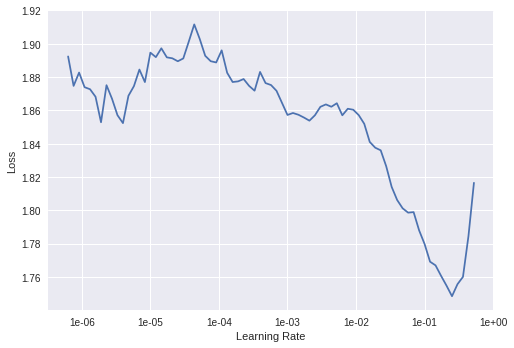

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [0]:
learn.fit_one_cycle(5, max_lr=slice(5e-03))

epoch,train_loss,valid_loss,time
0,0.935784,0.950368,00:12
1,0.854687,0.876014,00:13
2,0.773239,0.835312,00:13
3,0.677223,0.813977,00:13
4,0.557886,0.813406,00:13


In [0]:
learn.save("stage-1")

## Interpretation

In [0]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [0]:
groupby_title_rating_count = rating_movie.groupby(title)["rating"].count()

In [0]:
print("The length of rating count (groupby title): {}".format(len(groupby_title_rating_count)))
print(groupby_title_rating_count[:10])

The length of rating count (groupby title): 1664
title
'Til There Was You (1997)                        9
1-900 (1994)                                     5
101 Dalmatians (1996)                          109
12 Angry Men (1957)                            125
187 (1997)                                      41
2 Days in the Valley (1996)                     93
20,000 Leagues Under the Sea (1954)             72
2001: A Space Odyssey (1968)                   259
3 Ninjas: High Noon At Mega Mountain (1998)      5
39 Steps, The (1935)                            59
Name: rating, dtype: int64


In [0]:
top_movies = groupby_title_rating_count.sort_values(ascending=False).index.values[:1000]

In [0]:
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

## Movie bias

In [0]:
movie_bias = learn.bias(top_movies, is_item=True)

In [0]:
movie_bias[:10]

tensor([0.5144, 0.3977, 0.3838, 0.3999, 0.0799, 0.1617, 0.2275, 0.3169, 0.2805,
        0.1506])

In [0]:
mean_ratings = rating_movie.groupby(title)["rating"].mean()

In [0]:
mean_ratings[:10]

title
'Til There Was You (1997)                      2.333333
1-900 (1994)                                   2.600000
101 Dalmatians (1996)                          2.908257
12 Angry Men (1957)                            4.344000
187 (1997)                                     3.024390
2 Days in the Valley (1996)                    3.225806
20,000 Leagues Under the Sea (1954)            3.500000
2001: A Space Odyssey (1968)                   3.969112
3 Ninjas: High Noon At Mega Mountain (1998)    1.000000
39 Steps, The (1935)                           4.050847
Name: rating, dtype: float64

In [0]:
movie_ratings_d = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
sorted(movie_ratings_d, key=lambda x: x[0])[:10]

[(tensor(-0.3570),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3472),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2882), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2682), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2553), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2478), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2427), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2365), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2286), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2239), 'Bio-Dome (1996)', 1.903225806451613)]

In [0]:
sorted(movie_ratings_d, key=lambda x: x[0], reverse=True)[:10]

[(tensor(0.6068), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5754), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5623), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5372), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5318), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5301), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5144), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4993), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4953), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4922), 'As Good As It Gets (1997)', 4.196428571428571)]

## Movie weights

In [0]:
movie_weights = learn.weight(top_movies, is_item=True)

In [0]:
movie_weights.shape

torch.Size([1000, 40])

In [0]:
movie_pca = movie_weights.pca(3)

In [0]:
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0, fac1, fac2 = movie_pca.t()

In [0]:
movie_comp = [(f, i) for f, i in zip(fac0, top_movies)]

In [0]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1468), 'Wrong Trousers, The (1993)'),
 (tensor(1.1208), 'Casablanca (1942)'),
 (tensor(1.0561), 'Close Shave, A (1995)'),
 (tensor(0.9974), 'Chinatown (1974)'),
 (tensor(0.9849), 'Lawrence of Arabia (1962)'),
 (tensor(0.9329), "One Flew Over the Cuckoo's Nest (1975)"),
 (tensor(0.9249), 'Ran (1985)'),
 (tensor(0.9247), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(0.9219), 'When We Were Kings (1996)'),
 (tensor(0.9186), '12 Angry Men (1957)')]

In [0]:
movie_comp = [(f, i) for f, i in zip(fac1, top_movies)]
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1195), 'Braveheart (1995)'),
 (tensor(1.1090), 'Titanic (1997)'),
 (tensor(1.0535), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.8780), 'Top Gun (1986)'),
 (tensor(0.8732), "It's a Wonderful Life (1946)"),
 (tensor(0.8667), "Mr. Holland's Opus (1995)"),
 (tensor(0.8632), 'American President, The (1995)'),
 (tensor(0.8509), 'Pretty Woman (1990)'),
 (tensor(0.8468), 'Hunt for Red October, The (1990)'),
 (tensor(0.8198), 'Independence Day (ID4) (1996)')]

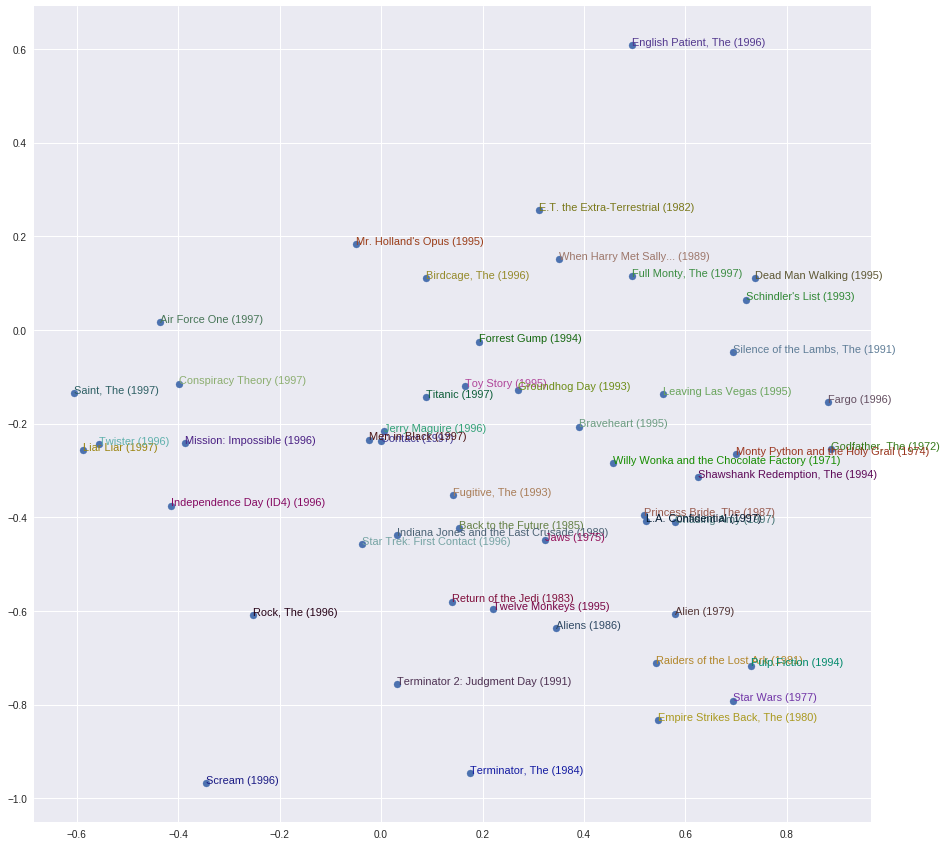

In [0]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()